In [ ]:
##

In [150]:
import sqlite3
import numpy as np
import pandas as pd 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import recordlinkage
from recordlinkage.preprocessing import clean

In [151]:
# Connect to the Database 
path = "zippedData/im.db"
conn = sqlite3.connect(path)
cursor = conn.cursor()

In [152]:
# to see all the tables in the database.

imdb_df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """
, conn
)

imdb_df[imdb_df['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [153]:
query1 = """ SELECT * FROM movie_basics ORDER BY -start_year LIMIT 10"""
pd.read_sql(query1, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt5174640,100 Years,100 Years,2115,None,Drama
1,tt5637536,Avatar 5,Avatar 5,2027,None,"Action,Adventure,Fantasy"
2,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,None,Fantasy
3,tt3095356,Avatar 4,Avatar 4,2025,None,"Action,Adventure,Fantasy"
4,tt10300396,Untitled Star Wars Film,Untitled Star Wars Film,2024,None,None
5,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,None,"Adventure,Family,Fantasy"
6,tt10255736,Untitled Marvel Project,Untitled Marvel Project,2023,None,Action
7,tt10298848,Untitled Disney Live-Action Project,Untitled Disney Live-Action Project,2023,None,None
8,tt1757678,Avatar 3,Avatar 3,2023,None,"Action,Adventure,Drama"
9,tt6258542,Wraith of the Umbra and Eidolon II,Wraith of the Umbra and Eidolon II,2023,None,"Adventure,Drama,Fantasy"


In [154]:
# get column info
cursor.execute("PRAGMA table_info(movie_basics)")
cursor.fetchall()

[(0, 'movie_id', 'TEXT', 0, None, 0),
 (1, 'primary_title', 'TEXT', 0, None, 0),
 (2, 'original_title', 'TEXT', 0, None, 0),
 (3, 'start_year', 'INTEGER', 0, None, 0),
 (4, 'runtime_minutes', 'REAL', 0, None, 0),
 (5, 'genres', 'TEXT', 0, None, 0)]

In [155]:
query4 = """ SELECT COUNT(*) FROM movie_basics"""
pd.read_sql(query4, conn)

,COUNT(*)
0,146144


In [156]:
query2 = """ SELECT * FROM movie_ratings LIMIT 5"""
pd.read_sql(query2, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8,31
1,tt10384606,9,559
2,tt1042974,6,20
3,tt1043726,4,50352
4,tt1060240,6,21


In [157]:
query11 = """ SELECT * FROM directors LIMIT 5"""
pd.read_sql(query11, conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [158]:
query201 = """
    WITH ranked_directors AS (
    SELECT
        d.movie_id,
        p.primary_name AS director_name,
        ROW_NUMBER() OVER (PARTITION BY d.movie_id ORDER BY d.person_id) AS director_rank
    FROM directors d
    JOIN persons p ON d.person_id = p.person_id
    GROUP BY d.movie_id, p.primary_name, d.person_id
),

ranked_principals AS (
    SELECT 
        p.movie_id,
        per.primary_name AS person_name,
        p.category,
        ROW_NUMBER() OVER (PARTITION BY p.movie_id, p.category ORDER BY p.person_id) AS person_rank
    FROM principals p
    JOIN persons per ON p.person_id = per.person_id
    WHERE p.category IN ('actor', 'actress', 'producer')
)

SELECT 
    mr.movie_id AS imdb_movie_id, 
    mb.primary_title, 
    mr.averagerating AS average_rating, 
    mr.numvotes, 
    mb.start_year, 
    mb.runtime_minutes, 
    mb.genres, 
    MAX(CASE WHEN rd.director_rank = 1 THEN rd.director_name END) AS director1, 
    MAX(CASE WHEN rd.director_rank = 2 THEN rd.director_name END) AS director2,
    MAX(CASE WHEN rp.category = 'actress' AND rp.person_rank = 1 THEN rp.person_name END) AS actress1,
    MAX(CASE WHEN rp.category = 'actress' AND rp.person_rank = 2 THEN rp.person_name END) AS actress2,
    MAX(CASE WHEN rp.category = 'actress' AND rp.person_rank = 3 THEN rp.person_name END) AS actress3,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 1 THEN rp.person_name END) AS actor1,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 2 THEN rp.person_name END) AS actor2,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 3 THEN rp.person_name END) AS actor3,
    MAX(CASE WHEN rp.category = 'actor' AND rp.person_rank = 4 THEN rp.person_name END) AS actor4,
    MAX(CASE WHEN rp.category = 'producer' AND rp.person_rank = 1 THEN rp.person_name END) AS producer1,
    MAX(CASE WHEN rp.category = 'producer' AND rp.person_rank = 2 THEN rp.person_name END) AS producer2
FROM movie_ratings mr
JOIN movie_basics mb ON mr.movie_id = mb.movie_id
LEFT JOIN ranked_directors rd ON mr.movie_id = rd.movie_id
LEFT JOIN ranked_principals rp ON mr.movie_id = rp.movie_id
WHERE mr.numvotes >= 30
GROUP BY 
    mr.movie_id, 
    mb.primary_title, 
    mr.averagerating, 
    mr.numvotes, 
    mb.start_year, 
    mb.runtime_minutes, 
    mb.genres
ORDER BY -mr.numvotes

"""
pd.read_sql(query201, conn)

,imdb_movie_id,primary_title,average_rating,numvotes,start_year,runtime_minutes,genres,director1,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,tt1375666,Inception,9,1841066,2010,148,"Action,Adventure,Sci-Fi",Christopher Nolan,None,Ellen Page,None,None,Leonardo DiCaprio,Joseph Gordon-Levitt,Ken Watanabe,None,Emma Thomas,None
1,tt1345836,The Dark Knight Rises,8,1387769,2012,164,"Action,Thriller",Christopher Nolan,None,Anne Hathaway,None,None,Gary Oldman,Christian Bale,Tom Hardy,None,Charles Roven,Emma Thomas
2,tt0816692,Interstellar,9,1299334,2014,169,"Adventure,Drama,Sci-Fi",Christopher Nolan,None,Anne Hathaway,Jessica Chastain,Mackenzie Foy,Matthew McConaughey,None,None,None,Lynda Obst,Emma Thomas
3,tt1853728,Django Unchained,8,1211405,2012,165,"Drama,Western",Quentin Tarantino,None,Kerry Washington,None,None,Leonardo DiCaprio,Jamie Foxx,Christoph Waltz,None,Reginald Hudlin,Pilar Savone
4,tt0848228,The Avengers,8,1183655,2012,143,"Action,Adventure,Sci-Fi",Joss Whedon,None,Scarlett Johansson,None,None,Robert Downey Jr.,Chris Evans,Jeremy Renner,None,Kevin Feige,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43735,tt9378760,Sarah Millican: Control Enthusiast Live,7,30,2018,82,Comedy,Brian Klein,None,None,None,None,None,None,None,None,None,None
43736,tt9442146,Hüddam 2,5,30,2019,92,"Drama,Horror,Thriller",Utku Uçar,None,Seyda Ipek Baykal,Ayyildiz Beslen,None,Hakan Erkuran,Can Beslen,None,None,Alpaslan Abdurrahman,None
43737,tt9598566,Ave Maria,7,30,2018,74,Drama,Vipin Radhakrishnan,None,Mekha Rajan,None,None,Ashand Raju,Reshma Malayath,Sabumon Abdusamad,None,None,None
43738,tt9613316,Frances Ferguson,7,30,2019,74,Comedy,Bob Byington,None,Jennifer Prediger,Kaley Wheless,None,Nick Offerman,Martin Starr,None,None,Zefrey Throwell,None


In [159]:
imdb_df = pd.read_sql(query201, conn)
imdb_df.head()

,imdb_movie_id,primary_title,average_rating,numvotes,start_year,runtime_minutes,genres,director1,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,tt1375666,Inception,9,1841066,2010,148,"Action,Adventure,Sci-Fi",Christopher Nolan,None,Ellen Page,None,None,Leonardo DiCaprio,Joseph Gordon-Levitt,Ken Watanabe,None,Emma Thomas,None
1,tt1345836,The Dark Knight Rises,8,1387769,2012,164,"Action,Thriller",Christopher Nolan,None,Anne Hathaway,None,None,Gary Oldman,Christian Bale,Tom Hardy,None,Charles Roven,Emma Thomas
2,tt0816692,Interstellar,9,1299334,2014,169,"Adventure,Drama,Sci-Fi",Christopher Nolan,None,Anne Hathaway,Jessica Chastain,Mackenzie Foy,Matthew McConaughey,None,None,None,Lynda Obst,Emma Thomas
3,tt1853728,Django Unchained,8,1211405,2012,165,"Drama,Western",Quentin Tarantino,None,Kerry Washington,None,None,Leonardo DiCaprio,Jamie Foxx,Christoph Waltz,None,Reginald Hudlin,Pilar Savone
4,tt0848228,The Avengers,8,1183655,2012,143,"Action,Adventure,Sci-Fi",Joss Whedon,None,Scarlett Johansson,None,None,Robert Downey Jr.,Chris Evans,Jeremy Renner,None,Kevin Feige,None


In [160]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43740 entries, 0 to 43739
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_movie_id    43740 non-null  object 
 1   primary_title    43740 non-null  object 
 2   average_rating   43740 non-null  float64
 3   numvotes         43740 non-null  int64  
 4   start_year       43740 non-null  int64  
 5   runtime_minutes  41466 non-null  float64
 6   genres           43619 non-null  object 
 7   director1        43528 non-null  object 
 8   director2        4352 non-null   object 
 9   actress1         33042 non-null  object 
 10  actress2         19261 non-null  object 
 11  actress3         6159 non-null   object 
 12  actor1           37258 non-null  object 
 13  actor2           32216 non-null  object 
 14  actor3           19403 non-null  object 
 15  actor4           6332 non-null   object 
 16  producer1        31705 non-null  object 
 17  producer2   

In [ ]:
#######################################################################################

In [161]:
# Read the CSV file
budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

# Display the first few rows of the DataFrame
print(budgets_df.tail(20))

      id  release_date                            movie production_budget  \
5762  63  Apr 11, 1997                   Pink Flamingos           $12,000   
5763  64  Apr 28, 2006         Grip: A Criminal's Story           $12,000   
5764  65  Dec 31, 2007                      Tin Can Man           $12,000   
5765  66   Mar 9, 2001                          Dayereh           $10,000   
5766  67  Apr 28, 2006                            Clean           $10,000   
5767  68   Jul 6, 2001                             Cure           $10,000   
5768  69  May 28, 2004                   On the Downlow           $10,000   
5769  70   Apr 1, 1996                             Bang           $10,000   
5770  71  Aug 14, 2008  The Rise and Fall of Miss Thang           $10,000   
5771  72  May 19, 2015                 Family Motocross           $10,000   
5772  73  Jan 13, 2012                        Newlyweds            $9,000   
5773  74  Feb 26, 1993                      El Mariachi            $7,000   

In [162]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [163]:
# convert release_dat column to datetime
budgets_df['release_date'] = pd.to_datetime(budgets_df['release_date'], format='%b %d, %Y')

In [164]:
# add a new column with just the year
budgets_df['release_year'] = budgets_df['release_date'].dt.year
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


In [165]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
 6   release_year       5782 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(4)
memory usage: 293.7+ KB


In [166]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43740 entries, 0 to 43739
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_movie_id    43740 non-null  object 
 1   primary_title    43740 non-null  object 
 2   average_rating   43740 non-null  float64
 3   numvotes         43740 non-null  int64  
 4   start_year       43740 non-null  int64  
 5   runtime_minutes  41466 non-null  float64
 6   genres           43619 non-null  object 
 7   director1        43528 non-null  object 
 8   director2        4352 non-null   object 
 9   actress1         33042 non-null  object 
 10  actress2         19261 non-null  object 
 11  actress3         6159 non-null   object 
 12  actor1           37258 non-null  object 
 13  actor2           32216 non-null  object 
 14  actor3           19403 non-null  object 
 15  actor4           6332 non-null   object 
 16  producer1        31705 non-null  object 
 17  producer2   

In [167]:
budgets_df['release_year'] = budgets_df['release_year'].astype('int64')

In [168]:
# Check for missing values in each column
budgets_df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
release_year         0
dtype: int64

In [169]:
imdb_df.isnull().sum()

imdb_movie_id          0
primary_title          0
average_rating         0
numvotes               0
start_year             0
runtime_minutes     2274
genres               121
director1            212
director2          39388
actress1           10698
actress2           24479
actress3           37581
actor1              6482
actor2             11524
actor3             24337
actor4             37408
producer1          12035
producer2          27328
dtype: int64

In [170]:
#######################################################################################

In [171]:
# record_linkage

In [172]:
# Suppress scientific notation and display full numbers
pd.set_option('display.float_format', '{:.0f}'.format)

In [173]:
# Normalize titles by converting to lowercase and stripping spaces
budgets_df['movie'] = budgets_df['movie'].str.lower().str.strip()
imdb_df['primary_title'] = imdb_df['primary_title'].str.lower().str.strip()

In [174]:
# years have to match exactly but not movie titles
# Create an indexer and define the comparison criteria
indexer = recordlinkage.Index()
indexer.block(left_on='release_year', right_on='start_year')
candidate_links = indexer.index(budgets_df, imdb_df)

compare = recordlinkage.Compare()
compare.exact('release_year', 'start_year', label='year')
compare.string('movie', 'primary_title', method='jarowinkler', threshold=0.95, label='title')
features = compare.compute(candidate_links, budgets_df, imdb_df)

In [175]:
# Filter matches based on a threshold
matches = features[features.sum(axis=1) > 1.5]

In [176]:
# Merge the data frames based on the matches
budgets_df['index'] = budgets_df.index
imdb_df['index'] = imdb_df.index

matches.reset_index(inplace=True)
merged_df = pd.merge(budgets_df, matches, left_on='index', right_on='level_0')
merged_df = pd.merge(merged_df, imdb_df, left_on='level_1', right_on='index')

# Drop unnecessary columns and duplicates
merged_df.drop(columns=['index_x', 'index_y', 'level_0', 'level_1'], inplace=True)
merged_df.drop_duplicates(inplace=True)
merged_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,year,title,imdb_movie_id,...,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,2,2011-05-20,pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,1,1,tt1298650,...,None,Penélope Cruz,None,None,Johnny Depp,Geoffrey Rush,Ian McShane,None,None,None
1,3,2019-06-07,dark phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,1,1,tt6565702,...,None,Jennifer Lawrence,None,None,Nicholas Hoult,James McAvoy,Michael Fassbender,None,None,None
2,4,2015-05-01,avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,1,1,tt2395427,...,None,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Kevin Feige,None
3,7,2018-04-27,avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",2018,1,1,tt4154756,...,Joe Russo,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,None,None
4,9,2017-11-17,justice league,"$300,000,000","$229,024,295","$655,945,209",2017,1,1,tt0974015,...,None,Gal Gadot,None,None,Ben Affleck,Jason Momoa,Ezra Miller,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,35,2013-10-25,her cry: la llorona investigation,"$35,000",$0,$0,2013,1,1,tt2469216,...,None,Nichole Ceballos,None,None,Ron Gelner,Everardo Guzman,James Ezrin,None,Hai Nguyen,None
1596,49,2015-09-01,exeter,"$25,000",$0,"$489,792",2015,1,1,tt1945044,...,None,Brittany Curran,None,None,Stephen Lang,Kevin Chapman,Kelly Blatz,None,Trent Othick,Michael Corso
1597,52,2015-12-01,dutch kills,"$25,000",$0,$0,2015,1,1,tt2759066,...,None,Celestine Rae,None,None,R.L. Mann,Mikaal Bates,Tama Filianga,None,Liam Le Guillou,None
1598,59,2011-11-25,the ridges,"$17,300",$0,$0,2011,1,1,tt1781935,...,None,Alana Kaniewski,Robbie Barnes,None,Ryan Dunk,Robert Grant,None,None,None,None


In [177]:
# rearrange columns
columns = list(merged_df.columns)

# Move 'primary_title' next to 'movie'
columns.insert(columns.index('movie') + 1, columns.pop(columns.index('primary_title')))
merged_df = merged_df[columns]
merged_df

,id,release_date,movie,primary_title,production_budget,domestic_gross,worldwide_gross,release_year,year,title,...,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
0,2,2011-05-20,pirates of the caribbean: on stranger tides,pirates of the caribbean: on stranger tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,1,1,...,None,Penélope Cruz,None,None,Johnny Depp,Geoffrey Rush,Ian McShane,None,None,None
1,3,2019-06-07,dark phoenix,dark phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,1,1,...,None,Jennifer Lawrence,None,None,Nicholas Hoult,James McAvoy,Michael Fassbender,None,None,None
2,4,2015-05-01,avengers: age of ultron,avengers: age of ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,1,1,...,None,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Kevin Feige,None
3,7,2018-04-27,avengers: infinity war,avengers: infinity war,"$300,000,000","$678,815,482","$2,048,134,200",2018,1,1,...,Joe Russo,None,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,None,None
4,9,2017-11-17,justice league,justice league,"$300,000,000","$229,024,295","$655,945,209",2017,1,1,...,None,Gal Gadot,None,None,Ben Affleck,Jason Momoa,Ezra Miller,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,35,2013-10-25,her cry: la llorona investigation,her cry: la llorona investigation,"$35,000",$0,$0,2013,1,1,...,None,Nichole Ceballos,None,None,Ron Gelner,Everardo Guzman,James Ezrin,None,Hai Nguyen,None
1596,49,2015-09-01,exeter,exeter,"$25,000",$0,"$489,792",2015,1,1,...,None,Brittany Curran,None,None,Stephen Lang,Kevin Chapman,Kelly Blatz,None,Trent Othick,Michael Corso
1597,52,2015-12-01,dutch kills,dutch kills,"$25,000",$0,$0,2015,1,1,...,None,Celestine Rae,None,None,R.L. Mann,Mikaal Bates,Tama Filianga,None,Liam Le Guillou,None
1598,59,2011-11-25,the ridges,the ridges,"$17,300",$0,$0,2011,1,1,...,None,Alana Kaniewski,Robbie Barnes,None,Ryan Dunk,Robert Grant,None,None,None,None


In [178]:
# Filter rows where 'movie' does not equal 'primary_title'
non_exact_matches = merged_df[merged_df['movie'] != merged_df['primary_title']]

# Set display options to show all rows
pd.set_option('display.max_rows', None)

non_exact_matches

,id,release_date,movie,primary_title,production_budget,domestic_gross,worldwide_gross,release_year,year,title,...,director2,actress1,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2
33,49,2017-05-05,guardians of the galaxy vol 2,guardians of the galaxy vol. 2,"$200,000,000","$389,813,101","$862,316,233",2017,1,1,...,None,Zoe Saldana,None,None,Vin Diesel,Chris Pratt,Dave Bautista,None,None,None
65,92,2018-07-27,mission: impossibleâfallout,mission: impossible - fallout,"$178,000,000","$220,159,104","$787,456,552",2018,1,1,...,None,None,None,None,Tom Cruise,Ving Rhames,Henry Cavill,Simon Pegg,J.J. Abrams,Jake Myers
97,32,2014-11-05,interstellar,interstelar,"$165,000,000","$188,017,894","$666,379,375",2014,1,1,...,Vladislav Krivenchuk,None,None,None,Viktor Murzikov,Sergey A.,Vladislav Krivenchuk,Dmitriy Khmelyov,None,None
103,40,2013-05-24,fast and furious 6,fast & furious 6,"$160,000,000","$238,679,850","$789,300,444",2013,1,1,...,None,Michelle Rodriguez,None,None,Vin Diesel,Dwayne Johnson,Paul Walker,None,Neal H. Moritz,Clayton Townsend
110,49,2015-07-01,terminator: genisys,terminator genisys,"$155,000,000","$89,760,956","$432,150,894",2015,1,1,...,None,Emilia Clarke,None,None,Arnold Schwarzenegger,Jason Clarke,Jai Courtney,None,David Ellison,None
122,76,2019-05-10,pokã©mon: detective pikachu,pokémon detective pikachu,"$150,000,000","$139,507,806","$411,258,433",2019,1,1,...,None,Kathryn Newton,None,None,Ryan Reynolds,Bill Nighy,Justice Smith,None,None,None
142,25,2012-11-16,"the twilight saga: breaking dawn, part 2",the twilight saga: breaking dawn - part 2,"$136,200,000","$292,324,737","$829,724,737",2012,1,1,...,None,Kristen Stewart,None,None,Peter Facinelli,Taylor Lautner,Robert Pattinson,None,Wyck Godfrey,Karen Rosenfelt
145,27,2015-12-25,the revenant,the event,"$135,000,000","$183,637,894","$532,938,302",2015,1,1,...,None,None,None,None,None,None,None,None,Maria Baker-Choustova,None
166,57,2011-11-18,"the twilight saga: breaking dawn, part 1",the twilight saga: breaking dawn - part 1,"$127,500,000","$281,287,133","$689,420,051",2011,1,1,...,None,Kristen Stewart,None,None,Gil Birmingham,Taylor Lautner,Robert Pattinson,None,Wyck Godfrey,Karen Rosenfelt
169,61,2011-07-15,harry potter and the deathly hallows: part ii,harry potter and the deathly hallows: part 2,"$125,000,000","$381,193,157","$1,341,693,157",2011,1,1,...,None,Emma Watson,None,None,Michael Gambon,Rupert Grint,Daniel Radcliffe,None,David Barron,David Heyman


In [179]:
# Reset display options to default
pd.reset_option('display.max_rows')

In [180]:
# remove movies with poorly matched titles by index
poor_match = [97, 145, 447, 495, 563, 853, 946, 1160, 1240, 1242]
merged_df = merged_df.drop(poor_match)

In [28]:
merged_df.columns

Index(['id', 'release_date', 'movie', 'primary_title', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'release_year', 'year', 'title',
       'imdb_movie_id', 'average_rating', 'numvotes', 'start_year',
       'runtime_minutes', 'genres', 'director1', 'director2', 'actress1',
       'actress2', 'actress3', 'actor1', 'actor2', 'actor3', 'actor4',
       'producer1', 'producer2'],
      dtype='object')

In [182]:
merged_df['start_year'].value_counts()

start_year
2015    199
2014    195
2011    192
2010    185
2013    180
2012    173
2016    170
2018    131
2017    124
2019     41
Name: count, dtype: int64

In [29]:
col_to_remove = ['id', 'movie', 'release_year', 'year', 'title', 'start_year', 'runtime_minutes']
merged_df = merged_df.drop(col_to_remove, axis=1)

In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, 0 to 1599
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1590 non-null   datetime64[ns]
 1   primary_title      1590 non-null   object        
 2   production_budget  1590 non-null   object        
 3   domestic_gross     1590 non-null   object        
 4   worldwide_gross    1590 non-null   object        
 5   imdb_movie_id      1590 non-null   object        
 6   average_rating     1590 non-null   float64       
 7   numvotes           1590 non-null   int64         
 8   genres             1590 non-null   object        
 9   director1          1589 non-null   object        
 10  director2          139 non-null    object        
 11  actress1           1383 non-null   object        
 12  actress2           730 non-null    object        
 13  actress3           177 non-null    object        
 14  actor1       

In [31]:
merged_df.isnull().sum()

release_date            0
primary_title           0
production_budget       0
domestic_gross          0
worldwide_gross         0
imdb_movie_id           0
average_rating          0
numvotes                0
genres                  0
director1               1
director2            1451
actress1              207
actress2              860
actress3             1413
actor1                 56
actor2                211
actor3                765
actor4               1411
producer1             210
producer2             593
dtype: int64

In [33]:
# convert string columns to numeric
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    merged_df[col] = merged_df[col].str.replace('$', '', regex=False)
    merged_df[col] = merged_df[col].str.replace(',', '', regex=False)
    merged_df[col] = pd.to_numeric(merged_df[col])

In [35]:
# Calculate profit
merged_df['profit'] = merged_df['worldwide_gross'] - merged_df['production_budget']

In [36]:
# Calculate ROI
merged_df['roi'] = (merged_df['profit'] / merged_df['production_budget']) * 100

In [37]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, 0 to 1599
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1590 non-null   datetime64[ns]
 1   primary_title      1590 non-null   object        
 2   production_budget  1590 non-null   int64         
 3   domestic_gross     1590 non-null   int64         
 4   worldwide_gross    1590 non-null   int64         
 5   imdb_movie_id      1590 non-null   object        
 6   average_rating     1590 non-null   float64       
 7   numvotes           1590 non-null   int64         
 8   genres             1590 non-null   object        
 9   director1          1589 non-null   object        
 10  director2          139 non-null    object        
 11  actress1           1383 non-null   object        
 12  actress2           730 non-null    object        
 13  actress3           177 non-null    object        
 14  actor1       

In [38]:
merged_df.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,imdb_movie_id,average_rating,numvotes,genres,director1,...,actress2,actress3,actor1,actor2,actor3,actor4,producer1,producer2,profit,roi
0,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875,1045663875,tt1298650,6.6,447624,"Action,Adventure,Fantasy",Rob Marshall,...,None,None,Johnny Depp,Geoffrey Rush,Ian McShane,None,None,None,635063875,154.667286
1,2019-06-07,dark phoenix,350000000,42762350,149762350,tt6565702,6.0,24451,"Action,Adventure,Sci-Fi",Simon Kinberg,...,None,None,Nicholas Hoult,James McAvoy,Michael Fassbender,None,None,None,-200237650,-57.210757
2,2015-05-01,avengers: age of ultron,330600000,459005868,1403013963,tt2395427,7.3,665594,"Action,Adventure,Sci-Fi",Joss Whedon,...,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,Kevin Feige,None,1072413963,324.384139
3,2018-04-27,avengers: infinity war,300000000,678815482,2048134200,tt4154756,8.5,670926,"Action,Adventure,Sci-Fi",Anthony Russo,...,None,None,Robert Downey Jr.,Chris Evans,Mark Ruffalo,Chris Hemsworth,None,None,1748134200,582.711400
4,2017-11-17,justice league,300000000,229024295,655945209,tt0974015,6.5,329135,"Action,Adventure,Fantasy",Zack Snyder,...,None,None,Ben Affleck,Jason Momoa,Ezra Miller,None,None,None,355945209,118.648403


In [39]:
# Split the genres column into multiple columns
merged_df[['genre1', 'genre2', 'genre3']] = merged_df['genres'].str.split(',', expand=True)
# expand=True: Ensures that the result is split into separate columns instead of a list.

In [40]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, 0 to 1599
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       1590 non-null   datetime64[ns]
 1   primary_title      1590 non-null   object        
 2   production_budget  1590 non-null   int64         
 3   domestic_gross     1590 non-null   int64         
 4   worldwide_gross    1590 non-null   int64         
 5   imdb_movie_id      1590 non-null   object        
 6   average_rating     1590 non-null   float64       
 7   numvotes           1590 non-null   int64         
 8   genres             1590 non-null   object        
 9   director1          1589 non-null   object        
 10  director2          139 non-null    object        
 11  actress1           1383 non-null   object        
 12  actress2           730 non-null    object        
 13  actress3           177 non-null    object        
 14  actor1       

In [41]:
merged_df.isnull().sum()

release_date            0
primary_title           0
production_budget       0
domestic_gross          0
worldwide_gross         0
imdb_movie_id           0
average_rating          0
numvotes                0
genres                  0
director1               1
director2            1451
actress1              207
actress2              860
actress3             1413
actor1                 56
actor2                211
actor3                765
actor4               1411
producer1             210
producer2             593
profit                  0
roi                     0
genre1                  0
genre2                182
genre3                544
dtype: int64

In [ ]:
####################################################################################

## Genre analisys

In [51]:
# Melting the genre columns
melted_genres_df = merged_df.melt(id_vars=['profit', 'roi', 'average_rating', 'numvotes'], 
                                  value_vars=['genre1', 'genre2', 'genre3'], 
                                  value_name='genre').dropna(subset=['genre'])

# Group by genre and calculate metrics
genre_analysis = melted_genres_df.groupby('genre').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

genre_analysis = genre_analysis.sort_values(by=['avg_roi', 'avg_rating'], ascending=[False, False])

genre_analysis

,genre,avg_profit,avg_roi,avg_rating,total_votes
14,Mystery,7.178859e+07,882.921748,6.103788,16594459
11,Horror,5.378518e+07,801.168485,5.454922,12523815
18,Thriller,8.552890e+07,532.830018,5.997080,32491608
12,Music,6.139344e+07,282.884445,6.326415,3572520
3,Biography,5.663079e+07,258.107437,7.012950,15425091
2,Animation,2.620077e+08,257.605378,6.492857,13066701
16,Sci-Fi,2.431463e+08,256.706369,6.414286,37240239
15,Romance,4.602440e+07,248.426585,6.302956,16168782
7,Drama,4.972870e+07,219.251678,6.526115,75170946
9,Fantasy,1.682634e+08,218.222772,6.113433,21040550


In [102]:
# Grouping by genre combinations (the 'genres' column)
genre_combinations_analysis = merged_df.groupby('genres').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

genre_combinations_analysis = genre_combinations_analysis.sort_values(by='avg_roi', ascending=False)
genre_combinations_analysis.head(20)

,genres,avg_profit,avg_roi,avg_rating,total_votes
225,"Horror,Mystery,Thriller",9.789205e+07,2714.189569,5.533333,2662668
176,"Drama,Family,Mystery",9.367782e+07,1873.556320,4.600000,58
107,"Biography,Drama,Fantasy",4.087804e+07,1167.944000,5.400000,24351
222,Horror,6.458132e+07,910.338018,4.290476,384848
137,"Comedy,Fantasy",1.398364e+08,816.138009,5.920000,1112690
22,"Action,Comedy,Documentary",1.516858e+08,758.428965,7.000000,53289
123,"Comedy,Documentary",1.679358e+07,752.441810,6.700000,21095
90,"Adventure,Horror,Mystery",3.682407e+07,736.481320,6.200000,66892
198,"Drama,Mystery",1.413155e+07,706.577550,7.200000,127751
215,"Family,Fantasy,Musical",1.099200e+09,686.999816,7.200000,238325


In [108]:
# Filter the DataFrame for the specific genre combination
horror_mystery_thriller_df = merged_df[merged_df['genres'] == 'Horror,Mystery,Thriller']

# Group by directors and calculate performance metrics
director_performance = horror_mystery_thriller_df.groupby('director1').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum'),
    movie_count=('director1', 'size')  # Count how many movies each director has in this genre combination
).reset_index()

# Sort the directors by average ROI or another metric you want to prioritize
best_director = director_performance.sort_values(by='avg_roi', ascending=False)

# Display the top directors based on ROI
best_director.head(10)

,director1,avg_profit,avg_roi,avg_rating,total_votes,movie_count
4,Chris Lofing,41556474.0,41556.474000,4.20,17763,1
2,Bradley Parker,41411721.0,4141.172100,5.00,60304,1
16,John R. Leonetti,250362920.0,3851.737231,5.40,122039,1
12,Henry Joost,169928918.0,3398.578360,5.20,144097,2
17,Jordan Peele,242289130.5,3089.205285,7.40,502985,2
13,James Wan,227460828.0,2314.215503,7.05,538461,2
5,Christopher Landon,102957557.0,2059.151140,5.75,124279,2
24,Stiles White,98300632.0,1966.012640,4.50,44054,1
8,David F. Sandberg,290384865.0,1935.899100,6.50,90402,1
19,M. Night Shyamalan,93677816.0,1873.556320,6.20,102459,1


In [106]:
# Filter for rows where any of genre1, genre2, or genre3 contains 'Horror', 'Mystery', or 'Thriller'
filtered_df = merged_df[
    (merged_df['genre1'].isin(['Horror', 'Mystery', 'Thriller'])) |
    (merged_df['genre2'].isin(['Horror', 'Mystery', 'Thriller'])) |
    (merged_df['genre3'].isin(['Horror', 'Mystery', 'Thriller']))
]

# Group by directors and calculate performance metrics
director_performance = filtered_df.groupby('director1').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum'),
    movie_count=('director1', 'size')  # Count how many movies each director has in this genre combination
).reset_index()

# Sort the directors by average ROI or another metric you want to prioritize
best_director = director_performance.sort_values(by='movie_count', ascending=False)

# Display the top directors based on ROI
best_director.head(10)

,director1,avg_profit,avg_roi,avg_rating,total_votes,movie_count
145,Jaume Collet-Serra,9.064333e+07,317.505124,6.620000,754056,5
46,Christopher Landon,6.541237e+07,1183.776703,6.025000,192220,4
86,Denis Villeneuve,7.678149e+07,163.691233,8.075000,1542153,4
59,Dan Gilroy,3.933810e+06,117.036862,6.666667,468321,3
161,John Erick Dowdle,4.267423e+07,675.637593,6.400000,259194,3
269,Ridley Scott,1.549929e+08,183.964714,6.233333,857736,3
134,James DeMonaco,9.977206e+07,1722.214364,6.066667,390006,3
19,Antoine Fuqua,1.180786e+08,181.681830,6.800000,635708,3
140,James Wan,5.945482e+08,1775.919597,7.100000,873535,3
234,Mike Flanagan,2.392347e+07,207.154795,6.166667,141706,3


In [103]:
# Grouping by genre combinations and calculating metrics
genre_combinations_analysis = merged_df.groupby('genres').agg(
    count=('genres', 'size'),  # Count the number of occurrences of each genre combination
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

# Filter for genre combinations with at least 30 occurrences
genre_combinations_analysis_filtered = genre_combinations_analysis[genre_combinations_analysis['count'] >= 30]

# Sort by average ROI to get the top ROI combinations
genre_combinations_analysis_filtered = genre_combinations_analysis_filtered.sort_values(by='avg_roi', ascending=False)

# Display the top 20 genre combinations based on average ROI
genre_combinations_analysis_filtered.head(20)

,genres,count,avg_profit,avg_roi,avg_rating,total_votes
225,"Horror,Mystery,Thriller",33,9.789205e+07,2714.189569,5.533333,2662668
203,"Drama,Romance",35,5.460891e+07,370.251773,6.820000,3008082
63,"Adventure,Animation,Comedy",72,2.920000e+08,292.655455,6.405556,8178889
12,"Action,Adventure,Sci-Fi",55,4.671189e+08,266.974470,6.730909,22181507
132,"Comedy,Drama,Romance",58,2.946711e+07,222.750310,6.377586,4758146
152,"Comedy,Romance",44,5.674938e+07,219.301651,5.854545,3215413
172,Drama,61,1.497891e+07,213.120406,6.704918,2879926
124,"Comedy,Drama",52,2.764650e+07,194.448467,6.440385,2985850
8,"Action,Adventure,Fantasy",33,2.477783e+08,148.954065,6.118182,7794508
21,"Action,Comedy,Crime",33,5.814870e+07,144.700516,6.033333,3794183


In [97]:
# Grouping by genre combinations (the 'genres' column)
genre_combinations_analysis = merged_df.groupby('genres').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

genre_combinations_analysis = genre_combinations_analysis.sort_values(by='avg_profit', ascending=False)
genre_combinations_analysis.head(20)

,genres,avg_profit,avg_roi,avg_rating,total_votes
215,"Family,Fantasy,Musical",1.099200e+09,686.999816,7.200000,238325
89,"Adventure,Fantasy,Mystery",8.354316e+08,668.345254,7.700000,425530
83,"Adventure,Drama,Sci-Fi",5.243254e+08,405.299553,8.300000,1979450
88,"Adventure,Fantasy",4.695440e+08,187.918683,7.166667,1127311
12,"Action,Adventure,Sci-Fi",4.671189e+08,266.974470,6.730909,22181507
78,"Adventure,Drama,Fantasy",4.438495e+08,604.969647,6.300000,2389231
174,"Drama,Family,Fantasy",4.395514e+08,462.685635,6.900000,142792
96,"Animation,Comedy,Family",3.518153e+08,474.764961,7.120000,967427
2,"Action,Adventure,Animation",3.394230e+08,260.867870,7.382353,3271715
4,"Action,Adventure,Comedy",3.169600e+08,296.084040,6.700000,6133789


In [96]:
merged_df.loc[merged_df['genres']== 'Family,Fantasy,Musical']

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,imdb_movie_id,average_rating,numvotes,genres,director1,...,actor3,actor4,producer1,producer2,profit,roi,genre1,genre2,genre3,all_cast
99,2017-03-17,beauty and the beast,160000000,504014165,1259199706,tt2771200,7.2,238325,"Family,Fantasy,Musical",Bill Condon,...,Luke Evans,None,None,None,1099199706,686.999816,Family,Fantasy,Musical,"Josh Gad,Dan Stevens,Luke Evans,Emma Watson"


In [101]:
# Grouping by genre combinations and calculating metrics
genre_combinations_analysis = merged_df.groupby('genres').agg(
    count=('genres', 'size'),  # Count the number of occurrences of each genre combination
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum')
).reset_index()

# Filter for genre combinations with at least 30 occurrences
genre_combinations_analysis_filtered = genre_combinations_analysis[genre_combinations_analysis['count'] >= 30]

# Sort by average profit to get the top profitable combinations
genre_combinations_analysis_filtered = genre_combinations_analysis_filtered.sort_values(by='avg_profit', ascending=False)

# Display the top 20 genre combinations based on average profit
genre_combinations_analysis_filtered.head(20)

,genres,count,avg_profit,avg_roi,avg_rating,total_votes
12,"Action,Adventure,Sci-Fi",55,4.671189e+08,266.974470,6.730909,22181507
63,"Adventure,Animation,Comedy",72,2.920000e+08,292.655455,6.405556,8178889
8,"Action,Adventure,Fantasy",33,2.477783e+08,148.954065,6.118182,7794508
225,"Horror,Mystery,Thriller",33,9.789205e+07,2714.189569,5.533333,2662668
6,"Action,Adventure,Drama",30,8.489867e+07,82.304742,5.963333,3590583
21,"Action,Comedy,Crime",33,5.814870e+07,144.700516,6.033333,3794183
152,"Comedy,Romance",44,5.674938e+07,219.301651,5.854545,3215413
203,"Drama,Romance",35,5.460891e+07,370.251773,6.820000,3008082
117,Comedy,63,4.124493e+07,124.589120,5.538095,3906958
132,"Comedy,Drama,Romance",58,2.946711e+07,222.750310,6.377586,4758146


In [109]:
# Filter for rows where any of genre1, genre2, or genre3 contains 'Action', 'Adventure', or 'Sci-Fi'
filtered_df = merged_df[
    (merged_df['genre1'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre2'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre3'].isin(['Action', 'Adventure', 'Sci-Fi']))
]

# Combine director1 and director2 into a single column for analysis
filtered_df = filtered_df.melt(id_vars=['profit'], value_vars=['director1', 'director2'], 
                               var_name='director_rank', value_name='director')

# Remove rows with missing director values
filtered_df = filtered_df[filtered_df['director'].notna()]

# Group by director and calculate average profit and number of movies
best_director_by_profit = filtered_df.groupby('director').agg(
    avg_profit=('profit', 'mean'),
    total_movies=('director', 'size')  # Count how many movies each director has directed
).reset_index()

# Sort by avg_profit to find the best directors
best_director_by_profit = best_director_by_profit.sort_values(by='avg_profit', ascending=False)

# Display the top 10 directors based on profit
best_director_by_profit.head(10)

,director,avg_profit,total_movies
110,Colin Trevorrow,1.433855e+09,1
280,Joss Whedon,1.182675e+09,2
227,James Wan,1.157809e+09,2
443,Ryan Coogler,1.148258e+09,1
212,J.A. Bayona,1.135773e+09,1
237,Jennifer Lee,1.122470e+09,1
88,Chris Buck,1.122470e+09,1
34,Anthony Russo,1.060869e+09,3
246,Joe Russo,1.060869e+09,3
304,Kyle Balda,1.023032e+09,2


In [110]:
# Filter for rows where genres exactly match 'Action, Adventure, Sci-Fi'
filtered_df = merged_df[merged_df['genres'] == 'Action,Adventure,Sci-Fi']

# Combine director1 and director2 into a single column for analysis
filtered_df = filtered_df.melt(id_vars=['profit', 'roi'], value_vars=['director1', 'director2'], 
                               var_name='director_rank', value_name='director')

# Remove rows with missing director values
filtered_df = filtered_df[filtered_df['director'].notna()]

# Group by director and calculate average profit, ROI, and total movies
best_directors_action_adventure_sci_fi = filtered_df.groupby('director').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    total_movies=('director', 'size')  # Count how many movies each director has directed
).reset_index()

# Sort by avg_profit to find the best directors
best_directors_action_adventure_sci_fi = best_directors_action_adventure_sci_fi.sort_values(by='avg_profit', ascending=False)

# Display the top 10 directors based on profit
best_directors_action_adventure_sci_fi.head(10)

,director,avg_profit,avg_roi,total_movies
7,Colin Trevorrow,1.433855e+09,666.909239,1
25,Joss Whedon,1.182675e+09,449.511158,2
38,Ryan Coogler,1.148258e+09,574.129112,1
16,J.A. Bayona,1.135773e+09,668.101646,1
20,Joe Russo,1.060869e+09,419.658523,3
3,Anthony Russo,1.060869e+09,419.658523,3
2,Anna Boden,9.480616e+08,541.749457,1
39,Ryan Fleck,9.480616e+08,541.749457,1
33,Michael Bay,7.362410e+08,359.955589,3
23,Jon Watts,7.051664e+08,402.952200,1


In [117]:
# Filter for rows where genres exactly match 'Action, Adventure, Sci-Fi'
filtered_df = merged_df[merged_df['genres'] == 'Action,Adventure,Sci-Fi']

# Combine all actress columns into a single column for analysis
actresses_df = filtered_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    total_movies=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by='total_movies', ascending=False)

# Display the top 10 actresses based on profit
best_actresses.head(10)

,actress,avg_profit,avg_roi,total_movies
24,Jennifer Lawrence,4.032945e+08,343.039999,7
47,Scarlett Johansson,9.091357e+08,416.967449,3
50,Zoe Saldana,2.140919e+08,113.752514,2
8,Bryce Dallas Howard,1.284814e+09,667.505443,2
20,Gwyneth Paltrow,7.332743e+08,386.541124,2
18,Emma Stone,5.234433e+08,249.496872,2
0,Adrianne Palicki,2.357407e+08,168.386218,1
37,Naomie Harris,3.080563e+08,256.713567,1
30,Lynn Collins,7.778100e+06,2.828400,1
31,Maika Monroe,2.191694e+08,132.829954,1


In [149]:
# Filter for rows where genres exactly match 'Action, Adventure, Sci-Fi'
filtered_df = merged_df[merged_df['genres'] == 'Action,Adventure,Sci-Fi']

# Combine all actress columns into a single column for analysis
actresses_df = filtered_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    total_movies=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Calculate a weighted score
best_actresses['score'] = best_actresses['avg_profit'] * best_actresses['total_movies']

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by='score', ascending=False)

# Display the top 10 actresses based on profit
best_actresses.head(10)

,actress,avg_profit,avg_roi,total_movies,score
24,Jennifer Lawrence,403294506,343,7,2823061545
47,Scarlett Johansson,909135733,417,3,2727407199
8,Bryce Dallas Howard,1284813832,668,2,2569627663
20,Gwyneth Paltrow,733274330,387,2,1466548661
25,Judy Greer,1433854864,667,1,1433854864
29,Lupita Nyong'o,1148258224,574,1,1148258224
11,Danai Gurira,1148258224,574,1,1148258224
18,Emma Stone,523443302,249,2,1046886603
6,Brie Larson,948061550,542,1,948061550
45,Rosie Huntington-Whiteley,928790543,476,1,928790543


In [119]:
# Combine all actor columns into a single column for analysis
actors_df = filtered_df.melt(id_vars=['profit', 'roi'], value_vars=['actor1', 'actor2', 'actor3', 'actor4'],
                             var_name='actor_rank', value_name='actor')

# Remove rows with missing actor values
actors_df = actors_df[actors_df['actor'].notna()]

# Group by actor and calculate average profit, ROI, and total movies
best_actors = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    total_movies=('actor', 'size')  # Count how many movies each actor appeared in
).reset_index()

# Sort by avg_profit to find the best actors
best_actors = best_actors.sort_values(by='total_movies', ascending=False)

# Display the top 10 actors based on profit
best_actors.head(10)


,actor,avg_profit,avg_roi,total_movies
86,Robert Downey Jr.,1.025038e+09,430.542275,7
20,Chris Evans,9.630875e+08,387.115097,6
65,Liam Hemsworth,5.365046e+08,452.878827,5
55,Josh Hutcherson,6.158383e+08,532.891046,4
41,James McAvoy,2.268927e+08,135.911799,4
73,Michael Fassbender,1.188670e+08,90.580888,4
78,Nicholas Hoult,1.281326e+08,98.105877,3
90,Samuel L. Jackson,5.743444e+08,342.226187,3
22,Chris Pine,2.140919e+08,113.752514,2
23,Chris Pratt,1.284814e+09,667.505443,2


In [125]:
# Filter for rows where any of genre1, genre2, or genre3 contains 'Action', 'Adventure', or 'Sci-Fi'
filtered_df = merged_df[
    (merged_df['genre1'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre2'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre3'].isin(['Action', 'Adventure', 'Sci-Fi']))
]

# Combine all actress columns into a single column for analysis
actresses_df = filtered_df.melt(id_vars=['profit', 'roi'], value_vars=['actress1', 'actress2', 'actress3'],
                                var_name='actress_rank', value_name='actress')

# Remove rows with missing actress values
actresses_df = actresses_df[actresses_df['actress'].notna()]

# Group by actress and calculate average profit, ROI, and total movies
best_actresses = actresses_df.groupby('actress').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    total_movies=('actress', 'size')  # Count how many movies each actress appeared in
).reset_index()

# Sort by avg_profit to find the best actresses
best_actresses = best_actresses.sort_values(by=['total_movies', 'avg_profit'], ascending=False)

# Display the top 10 actresses based on profit
best_actresses.head(10)

,actress,avg_profit,avg_roi,total_movies
146,Emily Blunt,117483491,333,11
230,Jennifer Lawrence,343583675,299,9
47,Anne Hathaway,427138689,249,7
299,Kristen Wiig,372930619,527,7
536,Zoe Saldana,253739744,158,7
44,Anna Kendrick,83669964,170,7
88,Cate Blanchett,395034150,241,6
92,Charlize Theron,144935146,136,6
484,Scarlett Johansson,640565133,469,5
298,Kristen Stewart,425372878,406,5


In [124]:
# Combine all actor columns into a single column for analysis
actors_df = filtered_df.melt(id_vars=['profit', 'roi'], value_vars=['actor1', 'actor2', 'actor3', 'actor4'],
                             var_name='actor_rank', value_name='actor')

# Remove rows with missing actor values
actors_df = actors_df[actors_df['actor'].notna()]

# Group by actor and calculate average profit, ROI, and total movies
best_actors = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    total_movies=('actor', 'size')  # Count how many movies each actor appeared in
).reset_index()

# Sort by avg_profit to find the best actors
best_actors = best_actors.sort_values(by='total_movies', ascending=False)

# Display the top 10 actors based on profit
best_actors.head(10)

,actor,avg_profit,avg_roi,total_movies
251,Dwayne Johnson,391458053,329,17
563,Liam Neeson,107727481,180,14
403,Jason Statham,236651372,150,13
140,Chris Hemsworth,381791671,178,12
820,Ryan Reynolds,213644236,269,12
467,Johnny Depp,237449034,105,12
114,Bruce Willis,71379815,217,11
379,James McAvoy,144332702,244,10
144,Chris Pine,165704445,158,10
128,Channing Tatum,122259856,167,10


In [133]:
# Step 1: Filter movies for the 'Action, Adventure, Sci-Fi' genre combination
filtered_movies = merged_df[merged_df['genres'] == 'Action,Adventure,Sci-Fi']

# Step 2: Gather producers from both producer1 and producer2
# Reshape the data to combine producers from both columns into a single column
producers = pd.concat([filtered_movies[['producer1', 'profit', 'roi']],
                       filtered_movies[['producer2', 'profit', 'roi']].rename(columns={'producer2': 'producer1'})])

# Step 3: Remove any rows where producer1 is NaN (if there are movies with only one producer)
producers = producers.dropna(subset=['producer1'])

# Step 4: Group by producer1 (all producers) and calculate average profit and ROI
best_producers = producers.groupby('producer1').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('producer1', 'count')  # To track the number of movies by the producer
).reset_index()

# Step 5: Sort producers by average profit and ROI, and filter to show only producers with at least one movie
best_producers = best_producers[best_producers['movie_count'] >= 1].sort_values(by='avg_profit', ascending=False)

# Step 6: Display the top producers
best_producers.head(10)

,producer1,avg_profit,avg_roi,movie_count
32,Patrick Crowley,1284813832,668,2
1,Belén Atienza,1135772799,668,1
23,Kevin Feige,938447882,436,5
16,Ian Bryce,736240986,360,3
7,Don Murphy,728675069,419,3
13,Emma Thomas,675524642,422,1
21,Jon Kilik,615838336,533,4
30,Nina Jacobson,615838336,533,4
5,Charles Roven,442999518,197,1
24,Kristie Macosko Krieger,429290136,286,1


In [137]:
# Filter for rows where any of genre1, genre2, or genre3 contains 'Action', 'Adventure', or 'Sci-Fi'
filtered_movies = merged_df[
    (merged_df['genre1'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre2'].isin(['Action', 'Adventure', 'Sci-Fi'])) |
    (merged_df['genre3'].isin(['Action', 'Adventure', 'Sci-Fi']))
]

# Step 2: Gather producers from both producer1 and producer2
# Reshape the data to combine producers from both columns into a single column
producers = pd.concat([filtered_movies[['producer1', 'profit', 'roi']],
                       filtered_movies[['producer2', 'profit', 'roi']].rename(columns={'producer2': 'producer1'})])

# Step 3: Remove any rows where producer1 is NaN (if there are movies with only one producer)
producers = producers.dropna(subset=['producer1'])

# Step 4: Group by producer1 (all producers) and calculate average profit and ROI
best_producers = producers.groupby('producer1').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    movie_count=('producer1', 'count')  # To track the number of movies by the producer
).reset_index()

# Step 5: Sort producers by average profit and ROI, and filter to show only producers with at least one movie
best_producers = best_producers[best_producers['movie_count'] >= 1].sort_values(by='avg_profit', ascending=False)

# Step 6: Display the top producers
best_producers.head(10)

,producer1,avg_profit,avg_roi,movie_count
57,Belén Atienza,1135772799,668,1
466,Peter Del Vecho,1122469910,748,1
439,Nicole Paradis Grindle,1042520711,521,1
288,John Walker,1042520711,521,1
49,Barbara Broccoli,910526981,455,1
317,Kevin Feige,867273996,415,6
77,Brigham Taylor,787854547,450,1
280,John C. Donkin,784765137,826,1
248,Janet Healy,758076558,1011,5
404,Michael Fottrell,746481830,458,4


In [139]:
# OVERALL best producers by avg_profit
# Melt the producers into a single column
producers = pd.melt(merged_df, id_vars=['profit'], value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Calculate a weighted score (you can adjust the formula as needed)
producer_analysis['score'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='score', ascending=False)

# Display the top producers
print(best_producers.head(10))

         producer_name  avg_profit  movie_count      score
741        Kevin Feige   867273996            6 5203643976
563        Janet Healy   724972930            6 4349837577
988     Neal H. Moritz   352200158           12 4226401895
318       David Heyman   618788012            6 3712728069
567         Jason Blum    82088706           39 3201459551
1366      Wyck Godfrey   219870498           14 3078186966
928   Michael Fottrell   746481830            4 2985927320
1031   Patrick Crowley   569513682            5 2847568412
1007     Nina Jacobson   283678932           10 2836789324
307       David Barron   546391103            5 2731955515


In [141]:
# Step 1: Melt the producers into a single column
producers = pd.melt(merged_df, id_vars=['profit', 'genre1', 'genre2', 'genre3'],
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Step 2: Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Step 3: Create a new DataFrame to count genres for each producer
genre_columns = ['genre1', 'genre2', 'genre3']
# Melt the genre columns into a long format
genres_melted = pd.melt(merged_df, id_vars=['producer1', 'producer2'], 
                         value_vars=genre_columns, 
                         var_name='genre_type', value_name='genre')

# Remove NaN genres
genres_melted = genres_melted.dropna(subset=['genre'])

# Combine producer and genre information
combined = producers.merge(genres_melted, left_on='producer_name', 
                           right_on='producer1', how='left')

# Count the most common genre for each producer
common_genres = combined.groupby('producer_name')['genre'].agg(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
common_genres.columns = ['producer_name', 'signature_genre']

# Step 4: Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Merge the common genres with the producer analysis
producer_analysis = producer_analysis.merge(common_genres, on='producer_name', how='left')

# Calculate a weighted score
producer_analysis['score'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='score', ascending=False)

# Display the top producers
best_producers.head(10)

,producer_name,avg_profit,movie_count,signature_genre,score
741,Kevin Feige,867273996,6,Action,5203643976
563,Janet Healy,724972930,6,Animation,4349837577
988,Neal H. Moritz,352200158,12,Action,4226401895
318,David Heyman,618788012,6,Adventure,3712728069
567,Jason Blum,82088706,39,Thriller,3201459551
1366,Wyck Godfrey,219870498,14,Drama,3078186966
928,Michael Fottrell,746481830,4,Action,2985927320
1031,Patrick Crowley,569513682,5,Action,2847568412
1007,Nina Jacobson,283678932,10,Drama,2836789324
307,David Barron,546391103,5,Drama,2731955515


In [144]:
# Step 1: Filter the DataFrame for the specified genres
filtered_df = merged_df[merged_df['genres'] == 'Action,Adventure,Sci-Fi']

# Step 2: Melt the producers into a single column
producers = pd.melt(filtered_df, id_vars=['profit'], 
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Step 3: Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Step 4: Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Step 5: Calculate a weighted score
producer_analysis['score'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Step 6: Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='score', ascending=False)

# Display the top producers
best_producers

,producer_name,avg_profit,movie_count,score
23,Kevin Feige,938447882,5,4692239410
32,Patrick Crowley,1284813832,2,2569627663
21,Jon Kilik,615838336,4,2463353344
30,Nina Jacobson,615838336,4,2463353344
16,Ian Bryce,736240986,3,2208722959
7,Don Murphy,728675069,3,2186025208
1,Belén Atienza,1135772799,1,1135772799
13,Emma Thomas,675524642,1,675524642
8,Donald De Line,224412814,2,448825628
5,Charles Roven,442999518,1,442999518


In [145]:
# Step 1: Create a mask for the specified genres
mask_action = merged_df['genres'] == 'Action,Adventure,Sci-Fi'
mask_adventure = merged_df['genre1'].isin(['Action', 'Adventure', 'Sci-Fi']) | \
                 merged_df['genre2'].isin(['Action', 'Adventure', 'Sci-Fi']) | \
                 merged_df['genre3'].isin(['Action', 'Adventure', 'Sci-Fi'])

# Combine the masks
filtered_df = merged_df[mask_action | mask_adventure]

# Step 2: Melt the producers into a single column
producers = pd.melt(filtered_df, id_vars=['profit'], 
                    value_vars=['producer1', 'producer2'], 
                    var_name='producer_type', value_name='producer_name')

# Step 3: Remove rows with NaN producers
producers = producers.dropna(subset=['producer_name'])

# Step 4: Group by producer name and calculate average profit and movie count
producer_analysis = producers.groupby('producer_name').agg(
    avg_profit=('profit', 'mean'),
    movie_count=('profit', 'count')
).reset_index()

# Step 5: Calculate a weighted score
producer_analysis['score'] = producer_analysis['avg_profit'] * producer_analysis['movie_count']

# Step 6: Sort by score to find the best producers
best_producers = producer_analysis.sort_values(by='score', ascending=False)

# Display the top producers
best_producers.head(10)

,producer_name,avg_profit,movie_count,score
317,Kevin Feige,867273996,6,5203643976
433,Neal H. Moritz,382036803,11,4202404828
248,Janet Healy,758076558,5,3790382788
137,David Heyman,742089267,5,3710446337
404,Michael Fottrell,746481830,4,2985927320
454,Patrick Crowley,569513682,5,2847568412
442,Nina Jacobson,615838336,4,2463353344
291,Jon Kilik,487318119,5,2436590596
598,Wyck Godfrey,471072595,5,2355362976
175,Emma Thomas,584045121,4,2336180484


## Director analisys

In [73]:
#  Analyze Individual Directors
# Melt the directors to treat them as individual rows
directors_df = merged_df.melt(id_vars=['profit', 'roi', 'average_rating', 'numvotes'], 
                               value_vars=['director1', 'director2'], 
                               value_name='director').dropna(subset=['director'])

# Group by director and calculate metrics
director_analysis = directors_df.groupby('director').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum'),
    count=('profit', 'size')  # Count of movies directed
).reset_index()

# Sort directors by average profit or ROI to see top performers
top_directors = director_analysis.sort_values(by='avg_profit', ascending=False)

top_directors

,director,avg_profit,avg_roi,avg_rating,total_votes,count
598,Joss Whedon,1.182675e+09,449.511158,7.700000,1849249,2
182,Chris Buck,1.122470e+09,748.313273,7.500000,516998,1
497,Jennifer Lee,1.122470e+09,748.313273,7.500000,516998,1
521,Joe Russo,1.060869e+09,419.658523,8.033333,1920685,3
76,Anthony Russo,1.060869e+09,419.658523,8.033333,1920685,3
...,...,...,...,...,...,...
246,Daniel Beard,-7.944858e+07,-88.276203,8.800000,53,1
1008,Sophon Sakdaphisit,-7.944858e+07,-88.276203,6.100000,629,1
164,Candy J. Beard,-7.944858e+07,-88.276203,8.800000,53,1
1004,Simon Wells,-1.104502e+08,-73.633495,5.400000,19823,1


In [71]:
# Analyze Director Combinations
# Filter only those rows with two directors
combined_directors_df = merged_df[merged_df['director2'].notnull()]

# Group by the combination of directors and calculate metrics
director_pairs_analysis = combined_directors_df.groupby(['director1', 'director2']).agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum'),
    count=('profit', 'size')  # Count of movies directed
).reset_index()

# Sort by average profit or ROI to see which pairs work well together
top_director_pairs = director_pairs_analysis.sort_values(by='avg_roi', ascending=False)

top_director_pairs

,director1,director2,avg_profit,avg_roi,avg_rating,total_votes,count
22,Chris Lofing,Travis Cluff,4.155647e+07,41556.474000,4.200000,17763,1
50,Henry Joost,Ariel Schulman,1.301700e+08,2350.139380,5.633333,246879,3
71,Kyle Balda,Pierre Coffin,1.023032e+09,1373.829428,6.350000,286497,2
40,Dinesh D'Souza,John Sullivan,3.084994e+07,1233.997640,5.100000,10133,1
114,Yarrow Cheney,Chris Renaud,8.117505e+08,1082.334045,6.500000,161997,1
...,...,...,...,...,...,...,...
80,Matthew R. Anderson,Edward Conna,-1.100000e+06,-100.000000,3.000000,791,1
69,Ken Del Conte,Hector Echavarria,-2.900000e+05,-100.000000,4.600000,33,1
90,Pamela J. Richardson,Al Franklin,-3.000000e+05,-100.000000,4.000000,34,1
76,Lisanne Pajot,James Swirsky,-1.000000e+05,-100.000000,7.700000,19538,1


## Actor/Actress analisys

In [75]:
# Analyze Individual Actors and Actresses
# Melt the DataFrame to get actors and actresses in a long format
actors_df = merged_df.melt(id_vars=['profit', 'roi', 'average_rating', 'numvotes'], 
                             value_vars=['actor1', 'actor2', 'actor3', 'actor4', 
                                         'actress1', 'actress2', 'actress3'], 
                             value_name='actor').dropna(subset=['actor'])

# Group by actor and calculate metrics
actor_analysis = actors_df.groupby('actor').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum'),
    count=('profit', 'size')  # Count of movies acted in
).reset_index()

# Sort actors by average profit or ROI to see top performers
top_actors = actor_analysis.sort_values(by='avg_profit', ascending=False)

top_actors.head(20)

,actor,avg_profit,avg_roi,avg_rating,total_votes,count
2987,Ty Simpkins,1.433855e+09,666.909239,7.00,539338,1
2099,Michael Gambon,1.216693e+09,973.354526,8.10,691835,1
2423,Rafe Spall,1.135773e+09,668.101646,6.20,219125,1
1164,Idina Menzel,1.122470e+09,748.313273,7.50,516998,1
1503,Jonathan Groff,1.122470e+09,748.313273,7.50,516998,1
2393,Pierre Coffin,1.086336e+09,1468.021855,6.40,193917,1
627,Craig T. Nelson,1.042521e+09,521.260356,7.70,203510,1
1150,Huck Milner,1.042521e+09,521.260356,7.70,203510,1
2676,Sarah Vowell,1.042521e+09,521.260356,7.70,203510,1
2979,Trey Parker,9.597278e+08,1279.637000,6.30,92580,1


In [76]:
# Analyze Actor and Actress Combinations

# Filter only those rows with multiple actors and actresses
combined_actors_df = merged_df[merged_df[['actor1', 'actor2', 'actor3', 'actor4', 
                                            'actress1', 'actress2', 'actress3']].notnull().any(axis=1)]

# Create combinations of actors and actresses
# You can use combinations from itertools if you want to analyze pairs
from itertools import combinations

def get_actor_pairs(row):
    actors = [row['actor1'], row['actor2'], row['actor3'], row['actor4']]
    actresses = [row['actress1'], row['actress2'], row['actress3']]
    all_cast = [a for a in actors + actresses if pd.notnull(a)]
    return list(combinations(all_cast, 2))

# Apply to create pairs
combined_actors_df['actor_pairs'] = combined_actors_df.apply(get_actor_pairs, axis=1)

# Explode the DataFrame to separate pairs into rows
exploded_pairs_df = combined_actors_df.explode('actor_pairs')

# Group by actor pair and calculate metrics
actor_pairs_analysis = exploded_pairs_df.groupby('actor_pairs').agg(
    avg_profit=('profit', 'mean'),
    avg_roi=('roi', 'mean'),
    avg_rating=('average_rating', 'mean'),
    total_votes=('numvotes', 'sum'),
    count=('profit', 'size')  # Count of movies for this pair
).reset_index()

# Sort by average profit or ROI to see which pairs work well together
top_actor_pairs = actor_pairs_analysis.sort_values(by='avg_profit', ascending=False)

top_actor_pairs.head(20)

/var/folders/lz/dlpss5nj2qddkgkk2xgdczn80000gn/T/ipykernel_17304/1128652810.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_actors_df['actor_pairs'] = combined_actors_df.apply(get_actor_pairs, axis=1)


,actor_pairs,avg_profit,avg_roi,avg_rating,total_votes,count
8557,"(Ty Simpkins, Judy Greer)",1.433855e+09,666.909239,7.000,539338,1
8556,"(Ty Simpkins, Bryce Dallas Howard)",1.433855e+09,666.909239,7.000,539338,1
1447,"(Chris Pratt, Ty Simpkins)",1.433855e+09,666.909239,7.000,539338,1
4737,"(Judy Greer, Bryce Dallas Howard)",1.433855e+09,666.909239,7.000,539338,1
1441,"(Chris Pratt, Judy Greer)",1.433855e+09,666.909239,7.000,539338,1
7227,"(Robert Downey Jr., Chris Hemsworth)",1.410274e+09,453.547769,7.900,1336520,2
7234,"(Robert Downey Jr., Mark Ruffalo)",1.410274e+09,453.547769,7.900,1336520,2
1376,"(Chris Evans, Mark Ruffalo)",1.410274e+09,453.547769,7.900,1336520,2
1370,"(Chris Evans, Chris Hemsworth)",1.410274e+09,453.547769,7.900,1336520,2
3780,"(Jason Statham, Paul Walker)",1.328723e+09,699.327786,7.200,335074,1


In [77]:
# Create a list of actors and actresses
merged_df['all_cast'] = merged_df[['actor1', 'actor2', 'actor3', 'actor4', 'actress1', 'actress2', 'actress3']].apply(lambda x: ','.join(x.dropna()), axis=1)

In [78]:
# Group by the combined cast
actor_performance = merged_df.groupby('all_cast').agg({
    'profit': 'mean',
    'roi': 'mean',
    'average_rating': 'mean',
    'numvotes': 'sum'
}).reset_index()

In [79]:
# Sort by profit or ROI or ratings
top_performers_by_profit = actor_performance.sort_values(by='profit', ascending=False).head(10)
top_performers_by_roi = actor_performance.sort_values(by='roi', ascending=False).head(10)
top_performers_by_rating = actor_performance.sort_values(by='average_rating', ascending=False).head(10)

In [81]:
top_performers_by_roi

,all_cast,profit,roi,average_rating,numvotes
1182,"Reese Mishler,Ryan Shoos,Cassidy Gifford,Pfeif...",41556474.0,41556.474000,4.2,17763
1349,"Simon Quarterman,Evan Helmuth,Ionut Grama,Fern...",100759490.0,10075.949000,4.2,33522
1021,"Micah Sloat,David Bierend,Molly Ephraim,Katie ...",174512032.0,5817.067733,5.7,93122
153,"Bradley Whitford,Daniel Kaluuya,Catherine Keen...",250367951.0,5007.359020,7.7,400474
946,"Mahershala Ali,Trevante Rhodes,Alex R. Hibbert...",63745512.0,4249.700800,7.4,227964
671,"Jesse McCartney,Nathan Phillips,Jonathan Sadow...",41411721.0,4141.172100,5.0,60304
239,"Christopher Nicholas Smith,Jessica Tyler Brown...",202039844.0,4040.796880,5.8,85689
1461,"Tony Amendola,Ward Horton,Alfre Woodard,Annabe...",250362920.0,3851.737231,5.4,122039
1123,"Patrick Fabian,Louis Herthum,Iris Bahr,Ashley ...",68365900.0,3798.105556,5.6,45815
1128,"Patrick Wilson,Barbara Hershey,Lin Shaye,Rose ...",156921515.0,3138.430300,6.6,141228


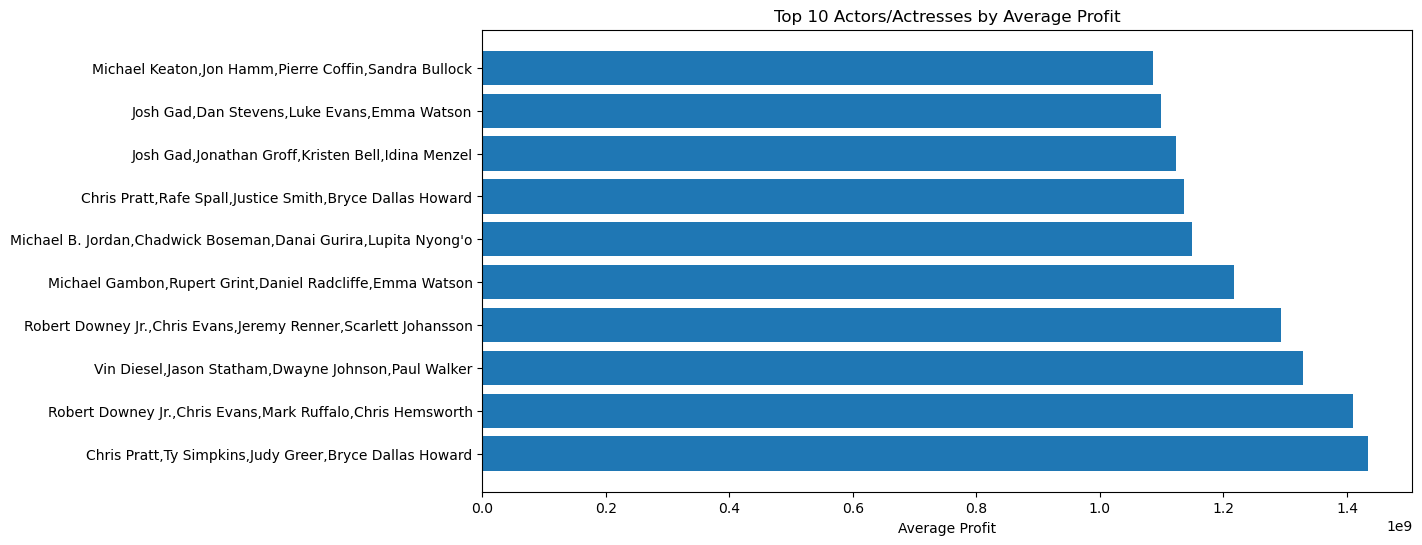

In [80]:
import matplotlib.pyplot as plt

# Bar plot for top 10 actors/actresses by profit
plt.figure(figsize=(12, 6))
plt.barh(top_performers_by_profit['all_cast'], top_performers_by_profit['profit'])
plt.xlabel('Average Profit')
plt.title('Top 10 Actors/Actresses by Average Profit')
plt.show()

In [ ]:
##

In [89]:
# analyze by actor
# Create a function to calculate the performance metrics for actors
def calculate_actor_performance(df, actor_col, metrics):
    # Group by actor
    actor_performance = df.groupby(actor_col).agg(metrics)
    return actor_performance

# Define the metrics you want to calculate
metrics = {
    'profit': 'mean',
    'roi': 'mean',
    'average_rating': 'mean',
    'numvotes': 'mean',
}

# Calculate performance for each actor
actor_performance = pd.concat([
    calculate_actor_performance(merged_df, 'actor1', metrics),
    calculate_actor_performance(merged_df, 'actor2', metrics),
    calculate_actor_performance(merged_df, 'actor3', metrics),
    calculate_actor_performance(merged_df, 'actor4', metrics),
]).groupby(level=0).mean()  # Combine results and take the mean

# Reset index to have a clean DataFrame
actor_performance = actor_performance.reset_index()

# Sort by profit or any other metric to find top performers
top_actors = actor_performance.sort_values(by='profit', ascending=False)
top_actors.head(10)

,index,profit,roi,average_rating,numvotes
1818,Ty Simpkins,1.433855e+09,666.909239,7.0,539338.0
1237,Michael Gambon,1.216693e+09,973.354526,8.1,691835.0
1436,Rafe Spall,1.135773e+09,668.101646,6.2,219125.0
931,Jonathan Groff,1.122470e+09,748.313273,7.5,516998.0
1426,Pierre Coffin,1.086336e+09,1468.021855,6.4,193917.0
672,Huck Milner,1.042521e+09,521.260356,7.7,203510.0
360,Craig T. Nelson,1.042521e+09,521.260356,7.7,203510.0
1812,Trey Parker,9.597278e+08,1279.637000,6.3,92580.0
1824,Tyrese Gibson,9.287905e+08,476.302843,6.2,366409.0
1753,Tim Allen,8.688795e+08,434.439761,8.3,682218.0


In [91]:
# Calculate performance for each actress
actress_performance = pd.concat([
    calculate_actor_performance(merged_df, 'actress1', metrics),
    calculate_actor_performance(merged_df, 'actress2', metrics),
    calculate_actor_performance(merged_df, 'actress3', metrics),
]).groupby(level=0).mean()  # Combine results and take the mean

# Reset index to have a clean DataFrame
actress_performance = actress_performance.reset_index()

# Sort by profit or any other metric to find top performers
top_actresses = actress_performance.sort_values(by='profit', ascending=False)
top_actresses.head(10)

,index,profit,roi,average_rating,numvotes
478,Idina Menzel,1.122470e+09,748.313273,7.50,516998.0
1077,Sarah Vowell,1.042521e+09,521.260356,7.70,203510.0
889,Miranda Cosgrove,9.294723e+08,1231.408523,6.85,218405.0
1028,Rosie Huntington-Whiteley,9.287905e+08,476.302843,6.20,366409.0
613,Karen Gillan,8.744962e+08,971.662437,7.00,242735.0
769,Lucy Boynton,8.399853e+08,1527.246076,8.00,345466.0
351,Ellen DeGeneres,8.212152e+08,410.607596,7.30,213542.0
603,Kaitlin Olson,8.212152e+08,410.607596,7.30,213542.0
904,Morena Baccarin,7.098531e+08,948.121376,7.90,606291.0
771,Lucy Davis,6.711334e+08,447.422252,7.50,487527.0


In [147]:
merged_df['genres'].value_counts().head(20)

genres
Adventure,Animation,Comedy    72
Comedy                        63
Drama                         61
Comedy,Drama,Romance          58
Action,Adventure,Sci-Fi       55
Comedy,Drama                  52
Comedy,Romance                44
Action,Crime,Drama            39
Drama,Romance                 35
Action,Adventure,Fantasy      33
Horror,Mystery,Thriller       33
Action,Comedy,Crime           33
Action,Adventure,Drama        30
Action,Crime,Thriller         28
Horror,Thriller               25
Drama,Thriller                25
Action,Adventure,Comedy       24
Crime,Drama,Thriller          22
Biography,Drama,History       22
Horror                        21
Name: count, dtype: int64

In [ ]:
###